<a href="https://colab.research.google.com/github/anniepeacock/DANSAR/blob/devel/Soil_Moisture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# SAR Application: Soil Moisture
### I. How to create SAR quicklook images of soil moisture? 

* Useful Products: HH or VV power time series
* Useful Wavelengths: L
* Relevant Sensors: Sentinel-1, ALOS, UAVSAR
* Instructions to View: 
* Qualitative Browse Products: How does the user know there is something in the image related to flooding before they develop/implement any algorithms? 

### II. How to interpret SAR images of soil moisture?
Soil moisture varies across space and time, and the amount of water in the soil is driven by  a number of factors including rainfall, soil texture, topography, and vegetation. Generally, rainfall is the primary input of moisture to the soil, and soil texture, vegetation, and topography influence water retention. 

For example, sandy soils are more porous than silty soils and tend to retain less water. Vegetation also tends to retain more water in the soil than bare surfaces. Meanwhile topography impacts where water accumulates. For example, flat surfaces tend to accumulate more water and for longer than steep surfaces, and in the northern hemisphere, soil in the south-facing slopes will tend to dry out faster than north-facing slopes. L-band's wavelength is approx 24 cm, which is helpful for soil moisture measurements as it can penetrate through the vegeation and into the soil. Soil moisture refers to the top few centimeters of the soil's surface. 

SAR data is sensitive to water in the soil due to the soil's dielectric properties, which can change significantly between wet and dry soils. "The radar signal interacts with different components of the land surface including the soil, vegeation, and soil-vegetation interactions." Therefore, to measure soil moisture, vegetation , temperature, and surface roughness have to be accounted for to understand how the different components are contributing to the returned signaal. Ancillary datasets can provide informationo about the other land surface components and assist with soil moisture retrieval. 

* Interpretation: Due to changes in the ground dielectric constant, VV backscatter increases when the soil surface is wet.


## SAR Example: Tonzi Ranch Soil Moisture

Tonzi Ranch is an Ameriflux site with a flux tower that collects continuous data for the Ameriflux database. Tonzi Ranch is an oak savanna woodland site, located in the foothills of Sierra Nevada Moutains. "The overstory is dominated by blue oak trees (40% of total vegetation) with intermittent grey pine trees (3 trees/ha). Understory species include a variety of grasses and herbs, including purple false brome, smooth cat's ear, and rose clover. These two distinctive layers operate in and out from one another. Growing season of the understory is confined to the wet season only, typically from October to early May. In contrast, the deciduous blue oak trees are dormant during the rainy winter months and reach maximum LAI in April. The blue oak ecosystem rings the Great Central Valley of California, inhabiting the lower reaches of the Sierra Nevada foothills" (https://ameriflux.lbl.gov/sites/siteinfo/US-Ton).

Tonzi Ranch. Image Credit: Dennis Baldocchi, 03/01/2006

The content of this notebook is as follows:
1. [Running the Notebook](#s1)
2. [Plot HV/HV Ratio](#s2)
3. [Histogram of VV Power Subset](#s3)
4. [VV Power Slideshow](#s4)

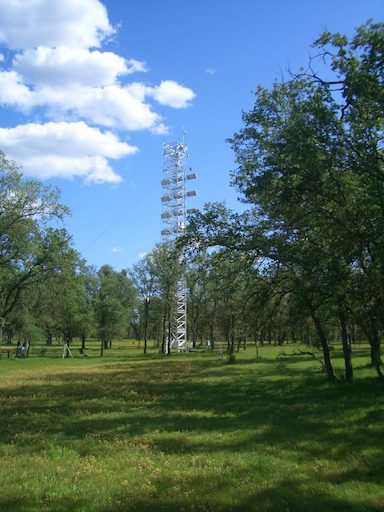

<a name="s1"></a>
## 1. Running the Notebook
- This Notebook has both "text" and "code" cells. The text cells have text descriptions about running the notebooks and data interpretation.
- Code cells are a light gray and a "play" button appears in the upper left corner when your mouse is hovered over the cell.
- To run the content in the code cells, **select the play button** in the upper left corner of each code cell or **press shift-enter**. 
- Code cells that are required for the notebook to run without errors are marked numerically with <font color='red'> Run cell below </font> 

### Python Packages:
This routine using the following python libaries. Some are already included in the Google Colab environment and others are installed in the cell below before imported. Downloading new python packages to this environment may take a few minutes to complete.

<font color='red'> 1. Run cell below </font> 

In [ ]:
# Install rasterio to Google Colab environment - this may take a few minutes.
!pip install rasterio --quiet

import rasterio as rio          # Read and write geospatial raster data
import rasterio.plot            # Plotting
from rasterio.plot import show  # Plotting

import matplotlib.pyplot as plt # Plotting, making graphs
import numpy as np              # Numeric and mathematic functions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 12.0 MB/s eta 0:00:00


<a name="s2"></a>
## 2. Plot HV/HV Ratio

UAVSAR line SMAP13_33006 collected data over Tonzi Ranch in 2014, the below line IDs are ordered from wet to dry conditions (or from winter through summer): 
* February 11, 2014: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SMAP13_33006_14017_006_140211_L090_CX_01#data
* April 01, 2014: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SMAP13_33006_14031_006_140401_L090_CX_01#data
* May 19, 2014: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SMAP13_33006_14063_009_140519_L090_CX_01#data
* August 14, 2014: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SMAP13_33006_14112_001_140814_L090_CX_01#data 

First, fetch UAVSAR geotiffs with wget. 

<font color='red'> 2. Run cell below </font> 

In [ ]:
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Soil_Moisture/SMAP13_33006_14017_006_140211_L090VVVV_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Soil_Moisture/SMAP13_33006_14031_006_140401_L090VVVV_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Soil_Moisture/SMAP13_33006_14063_009_140519_L090VVVV_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Soil_Moisture/SMAP13_33006_14112_001_140814_L090VVVV_CX_01.grd.tif --quiet

Then, read in the UAVSAR geotiffs.

<font color='red'> 3. Run cell below </font> 

In [ ]:
# Function to read geotiffs as an array
def read_file(path):
    with rio.open(path) as ds:
        band = ds.read(1)
    return band

# Read in UAVSAR VV geotiffs
VVFeb = read_file('SMAP13_33006_14017_006_140211_L090VVVV_CX_01.grd.tif')
VVApril = read_file('SMAP13_33006_14031_006_140401_L090VVVV_CX_01.grd.tif')
VVMay = read_file('SMAP13_33006_14063_009_140519_L090VVVV_CX_01.grd.tif')
VVAugust = read_file('SMAP13_33006_14112_001_140814_L090VVVV_CX_01.grd.tif')

# Test file
print(VVFeb)

[[0.16605757 0.11061964 0.06078611 ... 0.28153202 0.10064355 0.10064355]
 [0.04192192 0.04192192 0.08393466 ... 0.06194146 0.19636717 0.09800657]
 [0.03997448 0.0340693  0.09512027 ... 0.07364946 0.11651589 0.1277207 ]
 ...
 [0.0366099  0.19645071 0.13285683 ... 0.01617963 0.06631187 0.06631187]
 [0.08585986 0.12055087 0.12055087 ... 0.01638665 0.01288738 0.0307821 ]
 [0.01627554 0.05534352 0.13721023 ... 0.04989794 0.0274966  0.0274966 ]]


Plot each VV Power UAVSAR Image

<font color='red'> 4. Run cell below </font> 

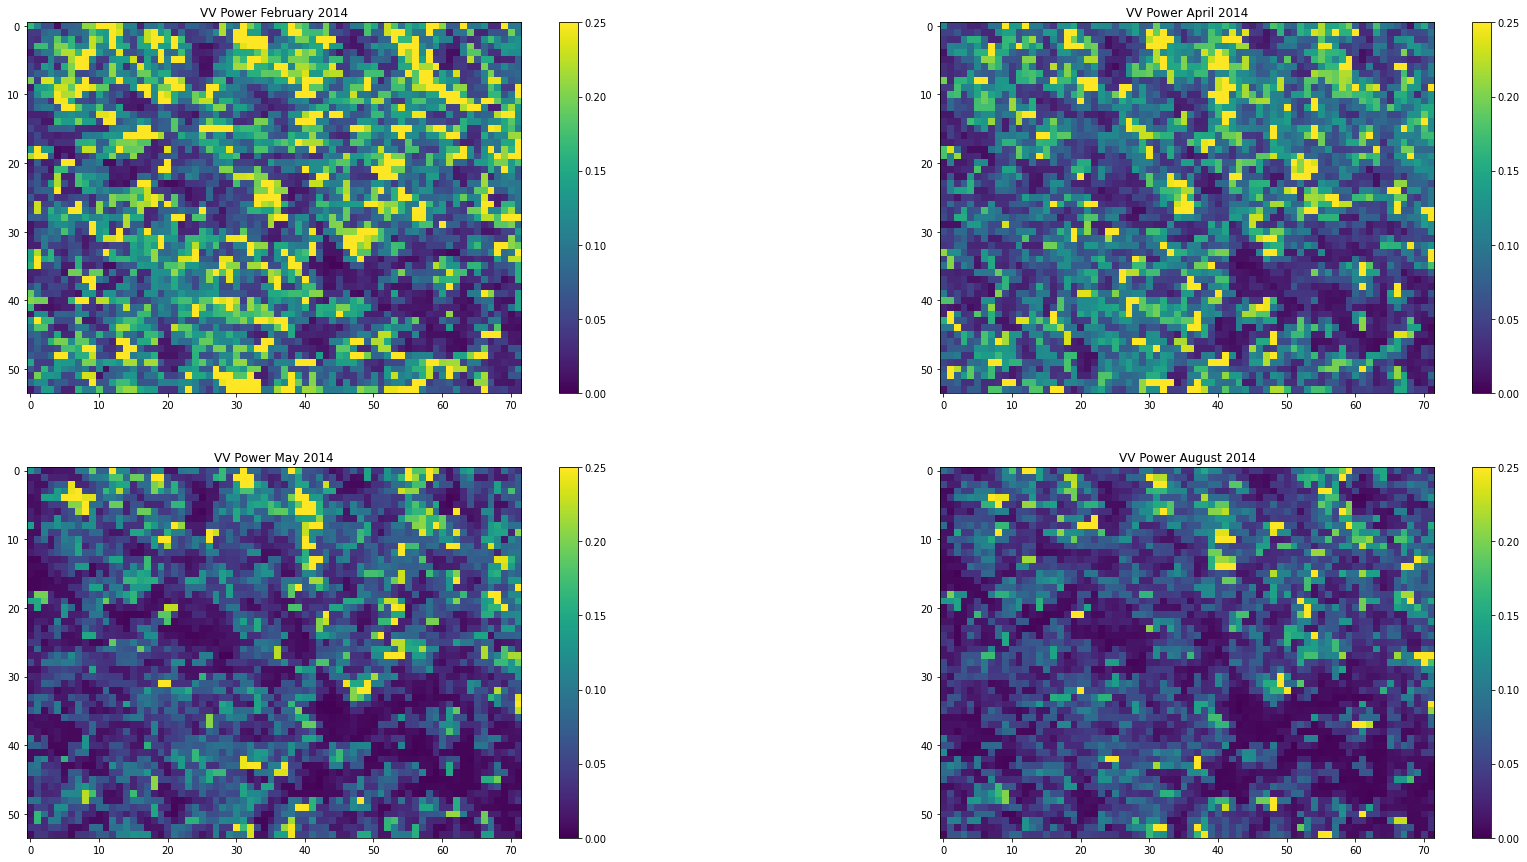

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(30, 15))
VV_Feb = ax[0,0].imshow(VVFeb, vmin=0, vmax=0.25) 
ax[0,0].set_title('VV Power February 2014')
fig.colorbar(VV_Feb, ax=ax[0,0])

VV_April = ax[0,1].imshow(VVApril, vmin=0, vmax=0.25) 
ax[0,1].set_title('VV Power April 2014')
fig.colorbar(VV_April, ax=ax[0,1])

VV_May = ax[1,0].imshow(VVMay, vmin=0, vmax=0.25) 
ax[1,0].set_title('VV Power May 2014')
fig.colorbar(VV_May, ax=ax[1,0])

VV_August = ax[1,1].imshow(VVAugust, vmin=0, vmax=0.25) 
ax[1,1].set_title('VV Power August 2014')
fig.colorbar(VV_August, ax=ax[1,1])

<a name="s3"></a>
## 3. Histogram of VV Power Subset
Plot the histogram of the above UAVSAR VV Power images over Tonzi Ranch.

<font color='red'> 5. Run cell below </font> 

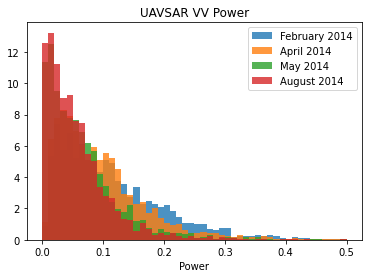

In [ ]:
# Plot histogram of VV Power
kwargs = dict(histtype='stepfilled', alpha=0.8, range=[0, 0.5], bins=50, density=True)

plt.hist(VVFeb.flatten(), **kwargs, label='February 2014')
plt.hist(VVApril.flatten(), **kwargs, label='April 2014')
plt.hist(VVMay.flatten(), **kwargs, label='May 2014');
plt.hist(VVAugust.flatten(), **kwargs, label='August 2014');

plt.xlabel('Power')
plt.ylabel('')
plt.title('UAVSAR VV Power')
plt.legend(prop={'size': 10})

<a name="s4"></a>
## 4. Ameriflux
VV Power for different dates, ensuring that all images have the same color scale. Focus on the Tonzi Ranch Ameriflux site.	VV power and corresponding plots with ground measurements from: https://ameriflux.lbl.gov/sites/siteinfo/US-Ton and https://airmoss.ornl.gov/visualize/


## References

Fang, B., Lakshmi, V., Jackson, T.J., Bindlish, R. Colliander, A. (2019). Passive/active microwave soil moisture change disaggregation using SMAPVEX12 data. Journal of Hydrology 574, 1085-1098. DOI: 10.1016/j.jhydrol.2019.04.082 (https://www.researchgate.net/publication/332758503_Passiveactive_microwave_soil_moisture_change_disaggregation_using_SMAPVEX12_Data)

Narvekar, P.S., Entekhabi, D., Kim, S.-B. Njoku, E.G. (2015). Soil Moisture Retrieval Using L-Band Radar Observations. IEEE Transactions on Geoscience and Remote Sensing 53, 3492-3506. DOI: 10.1109/TGRS.2014.2377714


Zwieback, S., Hensley, S. Hajnsek, I. (2015). Assessment of soil moisture effects on L-band radar interferometry. Remote Sensing of Environment 164, 77-89. DOI: 10.1016/j.rse.2015.04.012

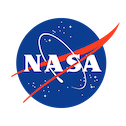

The research was carried out at the Jet Propulsion Laboratory, California Institute of Technology, under a contract with the National Aeronautics and Space Administration (80NM0018D0004)

© 2021. California Institute of Technology. Government sponsorship acknowledged. 